Le but est de créé ici de nouveaux VAE qui soient conditionnés sur la voix, de cette manière on aura un espace de representation beaucoup plus spécifique. 
Plusieurs manière de faire:


In [1]:
import torch
import torch.nn as nn 
from torch.utils.data import Dataset, DataLoader 
import os 
import numpy as np
import pandas as pd

In [5]:
#on récupère l'id du son
def get_soundID(soundpath):
    return soundpath.split('/')[-1].split('.')[0]

#puis on récupère l'id du locuteur
def get_speaker_identity(soundID,labFile):
    return labFile[labFile['sound_id'] == soundID]['client_id'].values[0]

#soundpaths --> soundpaths, speakerIDs
def get_identities(soundpaths,labFile):
    speakerID = []
    for soundpath in soundpaths:
        soundID = get_soundID(soundpath)
        speakerID = get_speaker_identity(soundID,labFile)
    return soundpaths,speakerID
    

## quelques tests sur le fichier labels 

In [8]:
#on charge le fichier labels.xslx
labFile = pd.read_excel('../../Data/charly/labels.xlsx')
#

In [ ]:
labFile.head()
#on affiche les dernieres lignes 
labFile.tail()

In [18]:
#on regarde combien il y a de sound_id différents
print(len(labFile['sound_id'].unique()))
print(len(labFile['client_id'].unique()))
print(labFile['client_id'].unique()[10])

182920
163
5790b443794f288e310477ac0093faf55c1e9a56d220546c602e21a98cb031683257d86c480f0e855694c313f90ba999a451a868a1cf44c2ae953ba2eb599f72


In [ ]:
#on filtre les données pour garder un seul client_id
labloc = labFile[labFile['client_id'] == '5790b443794f288e310477ac0093faf55c1e9a56d220546c602e21a98cb031683257d86c480f0e855694c313f90ba999a451a868a1cf44c2ae953ba2eb599f72']
print(len(labloc['sound_id'].unique()))
labloc.head()

## recupération des identités associées au son

In [6]:
test_wav = np.load("TrainValTest/testSet.npy")
labFile = pd.read_excel('../Data/charly/labels.xlsx')

In [ ]:
print(test_wav[0])
oneWav = test_wav[4]


get_soundID(oneWav)
get_speaker_identity(get_soundID(oneWav),labFile)


## test du cVAE

GROS PROBLEME : ROOTPATH DU DOWNLOADER A AJOUTER

In [3]:
import importlib as implib

#importation du downloader depuis un repertoire parent
import sys
#sys.path.append('../')
print(sys.path)

import downloader as dwl
import models.cVAE as cVAE
import models.modules.bottleneck as BN
import models.modules.CNNdecoder as CNNdec
import models.modules.CNNencoder as CNNenc

implib.reload(cVAE)
implib.reload(CNNdec)
implib.reload(CNNenc)
implib.reload(BN)
implib.reload(dwl)

['/home/hippo/Documents/voiceVAE', '/home/hippo/anaconda3/lib/python39.zip', '/home/hippo/anaconda3/lib/python3.9', '/home/hippo/anaconda3/lib/python3.9/lib-dynload', '', '/home/hippo/anaconda3/lib/python3.9/site-packages']


<module 'downloader' from '/home/hippo/Documents/voiceVAE/downloader.py'>

### on créé le bon dataloader

In [4]:
test_wav = np.load("TrainValTest/testSet.npy")
labFile = dwl.get_labels('../Data/charly/labels.xlsx')

In [6]:
torch.manual_seed(123)
spectros = dwl.conditionalDataset(test_wav,labFile=labFile)
valid_loader = DataLoader(spectros,batch_size=16,shuffle=False)

In [ ]:
print(len(valid_loader))
print(spectros[19][1])
print(len(spectros))

In [10]:
### OLD ###

# #labFile = pd.read_excel('../Data/charly/labels.xlsx')


# # on transforme le nom des client_ID
# list_loc = list(labFile['client_id'].unique())
# #new_list_loc = [i for i in range(len(list_loc))]
# labFile['client_id'] = labFile['client_id'].apply(lambda x: list_loc.index(x))


# #pour chaque test_wav on récupère le locuteur associé et on crée une liste de locuteurs
# test_locuteurs = []
# partial_wav = test_wav[:1000]
# for wav in partial_wav:
#     test_locuteurs.append(get_speaker_identity(get_soundID(wav),labFile))


# #validation_path = partial_wav, test_locuteurs  #TODO créer la fonction qui permet de récupérer les locuteurs 


### initialisation modele

In [17]:
model = cVAE.conditionalVAE(encoder= CNNenc.vanillaEncoder(64),
                            bottleneck= BN.VariationalBottleneck(64),
                            reconstructor= CNNdec.conditionalDecoder(64,10),  #ydim
                            beta=0)
# state_dic = torch.load("modelsParam/AE1D/ep5AE1D.pth")
# model.load_state_dict(state_dic)



In [45]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [ ]:
count_parameters(model)

In [18]:
batch = next(iter(valid_loader))

In [ ]:
# on transforme le vecteur avec un one hot encoding
#on transforme la liste en tenseur 
lbatch0 = torch.tensor(batch[1])
print(lbatch0)
batch[1] = torch.nn.functional.one_hot(lbatch0, num_classes=163)


In [19]:
print(batch[0].size())
print(batch[1].size())
print(batch[1][10])

torch.Size([16, 1, 401, 21])
torch.Size([16])
tensor(13)


In [339]:
#embeddings à changeeeeer
model.eval()
forward = model(batch[0], batch[1])  #,batch[1]
print(forward['logits'].size())

torch.Size([16, 1, 401, 21])


### entrainement du modèle

In [345]:
# entrainement du modele 

#Training loop
num_epochs = 5
device = 'cpu'
outputs = []
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)


for epoch in range(num_epochs):
    model.train()
    i=0
    print(f'Epoch {epoch+1}/{num_epochs}')
    for batch in valid_loader:      
        results = model(batch[0],batch[1]) ####ici on doit rajouter batch[1] (si bien coder, on peut réussir à gérer ça dans le modèle)
                                            #### comme ça on a une boucle de train plus générique
        recon = results['logits']
        loss, details = model.minibatch_loss(batch=batch[0], device= device, y= batch[1]) ###ici aussi à gérer la particularité du cVAE
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        i+=1
        if i % 10 == 0:
            print('batch', i , 'over' ,len(valid_loader))
        

    print(f'Epoch:{epoch+1}, Loss:{loss.item():.4f}')
    outputs.append((epoch, batch[0], recon))

    # model.eval()
    # val_losses = list()
    # with torch.no_grad():
    #     for batch in tqdm(stream.val_loader, desc=str(epoch), leave=False):
    #         loss, _ = model.minibatch_loss(batch, device, scaler)
    #         val_losses.append(loss)
    # val_loss = torch.mean(torch.stack(val_losses))
    # print(f'[epoch={epoch+1}] val loss: {val_loss.item()}')

Epoch 1/5
Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/home/hippo/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3369, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_5619/1059350305.py", line 18, in <cell line: 10>
    loss, details = model.minibatch_loss(batch=batch[0], device= device, y= batch[1]) ###ici aussi à gérer la particularité du cVAE
  File "/home/hippo/Documents/voiceVAE/models/cVAE.py", line 47, in minibatch_loss
    forward_data = self(targets,y)
  File "/home/hippo/anaconda3/lib/python3.9/site-packages/torch/nn/modules/module.py", line 727, in _call_impl
    result = self.forward(*input, **kwargs)
  File "/home/hippo/Documents/voiceVAE/models/cVAE.py", line 25, in forward
    logits = self.reconstructor(all_results['z'], y) # y on rajoute en input du reconstructor
  File "/home/hippo/anaconda3/lib/python3.9/site-packages/torch/nn/modules/module.py", line 727, in _call_impl
    result = self.forward(*input, **k

In [331]:
from copy import copy
trecon1 = copy(trecon)
outputs1 = copy(outputs)

In [ ]:
#

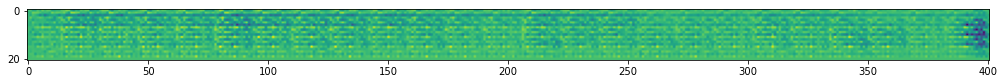

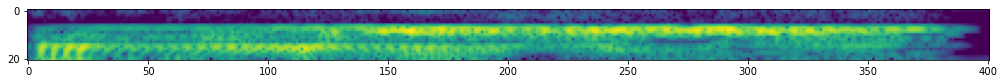

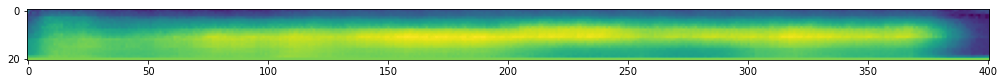

NEXT_SPECTRO


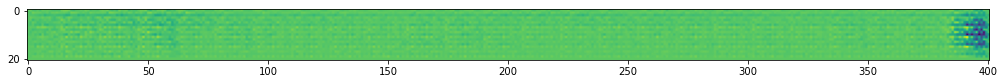

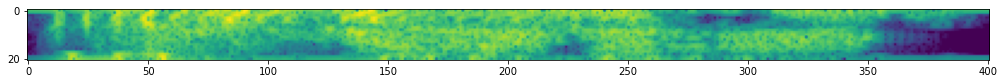

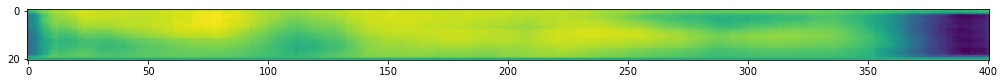

NEXT_SPECTRO


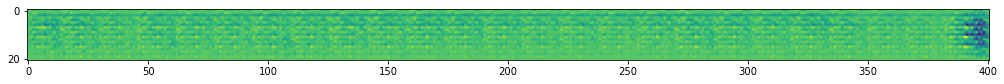

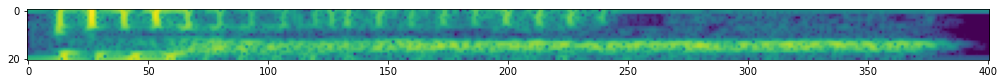

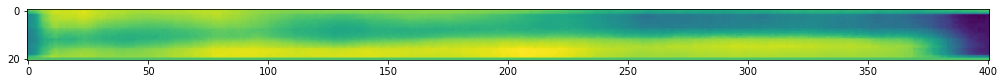

NEXT_SPECTRO


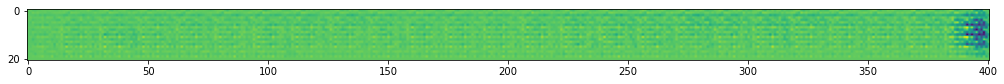

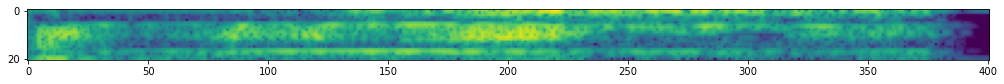

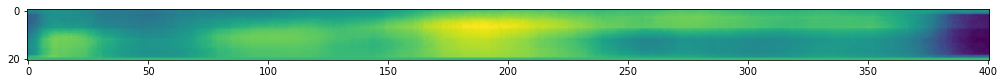

NEXT_SPECTRO


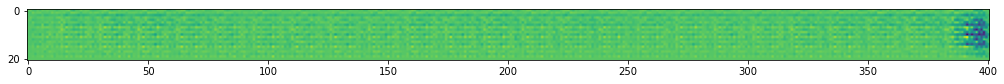

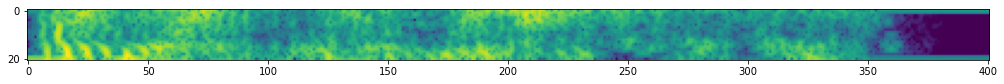

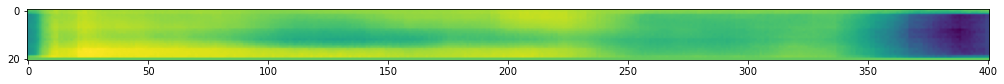

NEXT_SPECTRO


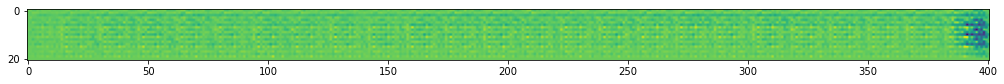

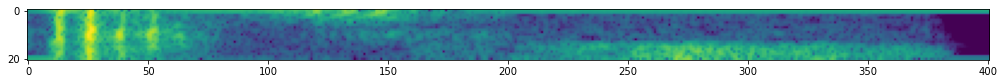

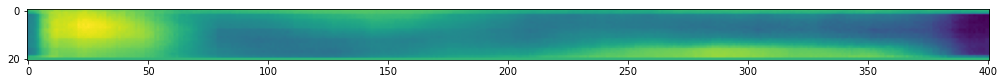

NEXT_SPECTRO


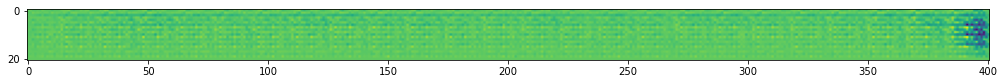

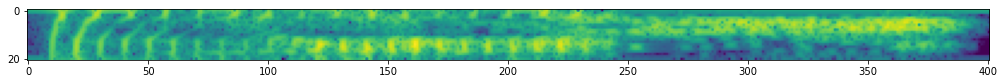

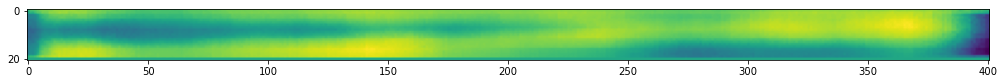

NEXT_SPECTRO


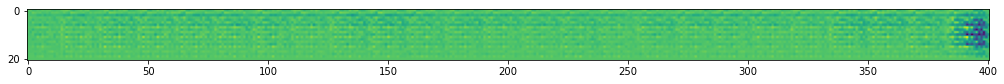

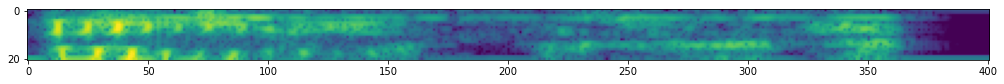

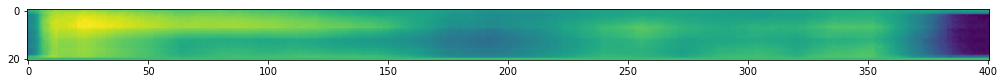

NEXT_SPECTRO


In [346]:
# on teste les resultats 
batch = next(iter(valid_loader))
results = model(batch[0],batch[1])
recon = results['logits']

trecon = recon.transpose(2,3)
tbatch = batch[0].transpose(2,3)

import matplotlib.pyplot as plt
#affichage des reocnstruction et des spectros originaux 
plt.rcParams['figure.figsize'] = [100, 50]
for i in range(8):
    plt.subplot(2,5,i+1)
    plt.imshow(trecon[i][0].detach().numpy())
    plt.show()
    plt.subplot(2,5,i+1)
    plt.imshow(tbatch[i][0].detach().numpy())
    plt.show()
    plt.subplot(2,5,i+1)
    plt.imshow(trecon1[i][0].detach().numpy())
    plt.show()
    #plt.imshow(trecon[i][0].detach().numpy()-tbatch[i][0].detach().numpy())
    print('NEXT_SPECTRO')

In [108]:
# on test la classe nn.Embedding
embedding = nn.Embedding(163, 10)
input = torch.LongTensor([4,3,2,9])
print(input.shape)
print(embedding(input))


torch.Size([4])
tensor([[ 0.6364,  1.0979,  1.8590,  0.7185, -0.6308, -0.7499, -0.2463,  0.1155,
         -0.8625,  1.1932],
        [ 0.0196,  0.0621,  1.9423,  0.7760, -0.2821, -0.0655,  0.6111, -1.1379,
         -0.0948, -1.9305],
        [-0.6927,  0.4907, -0.5598, -1.0373, -1.6063, -0.2231, -0.3577, -0.7482,
         -0.2606,  0.2394],
        [ 1.8657, -0.0778, -0.3129,  0.9962,  1.9069,  2.0962, -0.7134,  0.2556,
         -0.6387,  0.3119]], grad_fn=<EmbeddingBackward>)
